In [1]:
import os, sys
from itertools import product
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import torch
from torchdrug import core, models, tasks, utils
from torch_geometric.utils import is_undirected, to_undirected
%matplotlib inline

SEED = 43
NUM_BASIS_DRUGS = 6216
np.random.seed(SEED)

path_base = "/n/data1/hms/dbmi/zitnik/lab/users/yeh803/DDI/processed_data/PrimeKG-DDI/drug_centric_easy_split/"
pca_lookup = pd.read_csv(path_base+f"/deepDDI/lookup_table_of_pca_{NUM_BASIS_DRUGS}_seed{SEED}.csv", index_col=0).drop(columns=['node_id'])
drugs = pd.read_csv(path_base+"/kgddi_drug_split.csv", index_col=0)
train_edgelist = torch.load(path_base+'/train_edgelist.pt')
val_between_edgelist = torch.load(path_base+'/val_between_edgelist.pt')
val_within_edgelist = torch.load(path_base+'/val_within_edgelist.pt')

train_drugs_df = drugs[drugs.split=='train']
train_drugs_df['view_str'] = 1
val_drugs_df = drugs[drugs.split=='val']
val_drugs_df['view_str'] = 1

/home/nih492/.conda/envs/pygpu_nick/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_140401/2565493604.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_drugs_df['view_str'] = 1
/tmp/ipykernel_140401/2565493604.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_drugs_df['view_str'] = 1


### Constructing the tools for on-the-fly training

- Inputs:
    - train_edgelist
        - edgelist corresponding to the drug_index in train_drugs_df
    - drugs
        - a dataframe containing the drug_id, should have 3367 rows corresponding to the drugs we have DDIs for,
        however, we have in total ~6800 drug available in total drugs (including the pretraining drugs)


- adjacency matrix for the train_edgelist
- Drug_idx-to-PCA lookup table

In [94]:
# ## No Need to run

# from torch_geometric.utils import is_undirected, to_undirected, to_dense_adj, k_hop_subgraph, coalesce, structured_negative_sampling
# from torch.utils.data import DataLoader
# from torch_geometric.seed import seed_everything

# seed_everything(0)

# loader = DataLoader(train_edgelist, batch_size=5, shuffle=True)

# for batch_ddis in loader:
#     break

# def get_batch_embeddings(batch_ddis, pca_lookup, data_mode = "train"):

#     """Takes in the batch of ddis :torch.tensor: with shape of (num_edges, 2) and lookup and outputs the 
#     reformated data + appropriate negative sampling. For example, by inputting edge (A,B), it first adds (B,A)
#     as an additional positive edge, then adds (A, 1), (1,A), (B,2), (2,B) where 1 and 2 are negative edges
#     sampled within the batch. This will have to be adjusted for evaluation mode. 

#     Args:
#         batch_ddis (TorchTensor): The edge indices.
#         pca_lookup (pandas dataframe): pandas dataframe where the indices are set by the drug. 

#     :rtype: (Tensor, Tensor, Tensor, Tensor)
#     """

#     if data_mode == "train":

#         undir_pos_ddis = to_undirected(batch_ddis.T)  ## make undirected first, (A,B), (B,A)
#         heads, _, negatives = structured_negative_sampling(undir_pos_ddis) # because we set this to be undirected, we only need heads + negatives
#         neg_samps = torch.cat([heads.view(1, -1), negatives.view(1, -1)], dim = 0)
#         undir_neg_ddis = to_undirected(neg_samps) # set the negative samples to be undirected, (A,1), (1,A), (B,2), (2, B)

#         undir_pos_ddis = np.array(undir_pos_ddis) 
#         undir_neg_ddis = np.array(undir_neg_ddis)
#         lookup = pca_lookup.T

#         head_pos = lookup[undir_pos_ddis[0]].values.T 
#         tail_pos = lookup[undir_pos_ddis[1]].values.T
#         batch_pos = np.concatenate([head_pos, tail_pos], axis = 1)
#         batch_pos = torch.tensor(batch_pos)
#         pos_labels = torch.ones(batch_pos.shape[0]) 

#         head_neg = lookup[undir_neg_ddis[0]].values.T
#         tail_neg = lookup[undir_neg_ddis[1]].values.T
#         batch_neg = np.concatenate([head_neg, tail_neg], axis = 1)
#         batch_neg = torch.tensor(batch_neg)
#         neg_labels = torch.zeros(batch_neg.shape[0])

#         batch_ddis = torch.cat([batch_pos, batch_neg], dim = 0)
#         labels = torch.cat([pos_labels, neg_labels], dim = 0)

#         return (batch_ddis, labels)

#     elif data_mode == "val" or data_mode == "test":
#         raise ValueError('Val or test negative sampling on the fly not implemented yet')

#     else:
#         raise ValueError('Please input, val, test, or train')

# x, labels = get_batch_embeddings(batch_ddis, pca_lookup, data_mode = "test")



ValueError: Val or test negative sampling on the fly not implemented yet

### Validation and testing

- Yepeng has already created some useful splits that I will use directly.


In [2]:
path_base = "/n/data1/hms/dbmi/zitnik/lab/users/yeh803/DDI/processed_data/PrimeKG-DDI/drug_centric_easy_split/"

val_between_edgelist = torch.load(path_base+'/val_between_edgelist.pt')
val_within_edgelist = torch.load(path_base+'/val_within_edgelist.pt')
negative_val_between_edgelist = torch.load(path_base+'/negative_val_between_edgelist.pt')
negative_val_within_edgelist = torch.load(path_base+'/negative_val_within_edgelist.pt')

negative_val_between_edgelist.shape

torch.Size([544256, 2])

In [26]:
## Direct conversion and save as a pytorch objects
lookup = pca_lookup.T

##
# val between
##
head_pos = lookup[val_between_edgelist[:, 0]].values.T 
tail_pos = lookup[val_between_edgelist[:, 1]].values.T
val_btn_pos = np.concatenate([head_pos, tail_pos], axis = 1)
val_btn_pos = torch.tensor(val_btn_pos)
val_btn_labels_pos = torch.ones(val_btn_pos.shape[0]) 

head_neg = lookup[negative_val_between_edgelist[:, 0]].values.T 
tail_neg = lookup[negative_val_between_edgelist[:, 1]].values.T
val_btn_neg = np.concatenate([head_neg, tail_neg], axis = 1)
val_btn_neg = torch.tensor(val_btn_neg)
val_btn_labels_neg = torch.zeros(val_btn_neg.shape[0]) 

val_btn_ddis = torch.cat([val_btn_pos, val_btn_neg], dim = 0)
val_btn_labels = torch.cat([val_btn_labels_pos, val_btn_labels_neg], dim = 0)

torch.save(val_btn_ddis, path_base + '/deepDDI/val_btn_deepddi.pt')
torch.save(val_btn_labels, path_base + '/deepDDI/val_btn_deepddi_labels.pt')

In [27]:
##
# val within
##

val_within_edgelist
negative_val_within_edgelist

head_pos = lookup[val_within_edgelist[:, 0]].values.T 
tail_pos = lookup[val_within_edgelist[:, 1]].values.T
val_wtn_pos = np.concatenate([head_pos, tail_pos], axis = 1)
val_wtn_pos = torch.tensor(val_wtn_pos) 
val_wtn_labels_pos = torch.ones(val_wtn_pos.shape[0]) # positive labels

head_neg = lookup[negative_val_within_edgelist[:, 0]].values.T 
tail_neg = lookup[negative_val_within_edgelist[:, 1]].values.T
val_wtn_neg = np.concatenate([head_neg, tail_neg], axis = 1)
val_wtn_neg = torch.tensor(val_wtn_neg)
val_wtn_labels_neg = torch.zeros(val_wtn_neg.shape[0]) # negative labels

val_wtn_ddis = torch.cat([val_wtn_pos, val_wtn_neg], dim = 0)
val_wtn_labels = torch.cat([val_wtn_labels_pos, val_wtn_labels_neg], dim = 0)

# torch.save(val_wtn_ddis, path_base + f'/deepDDI/val_wtn_deepddi_{NUM_BASIS_DRUGS}_seed{SEED}.pt')
# torch.save(val_wtn_labels, path_base + f'/deepDDI/val_wtn_deepddi_labels_{NUM_BASIS_DRUGS}_seed{SEED}.pt')

torch.save(val_wtn_ddis, path_base + f'/deepDDI/val_wtn_deepddi.pt')
torch.save(val_wtn_labels, path_base + f'/deepDDI/val_wtn_deepddi_labels.pt')

: 

In [ ]:
val_wtn_ddis.shape

### and the train split for evaluation metric purposes, **not** for training

In [25]:
train_edgelist = torch.load(path_base+'/train_edgelist.pt')
negative_train_edgelist = torch.load(path_base+'/negative_train_edgelist.pt')


head_pos = lookup[train_edgelist[:, 0]].values.T 
tail_pos = lookup[train_edgelist[:, 1]].values.T
train_pos = np.concatenate([head_pos, tail_pos], axis = 1)
train_pos = torch.tensor(train_pos) 
train_labels_pos = torch.ones(train_pos.shape[0]) # positive labels

head_neg = lookup[negative_train_edgelist[:, 0]].values.T 
tail_neg = lookup[negative_train_edgelist[:, 1]].values.T
train_neg = np.concatenate([head_neg, tail_neg], axis = 1)
train_neg = torch.tensor(train_neg)
train_labels_neg = torch.zeros(train_neg.shape[0]) # negative labels

train_ddis = torch.cat([train_pos, train_neg], dim = 0)
train_labels = torch.cat([train_labels_pos, train_labels_neg], dim = 0)

torch.save(train_ddis, path_base + f'/deepDDI/train_EVAL_deepddi_{NUM_BASIS_DRUGS}_seed{SEED}.pt')
torch.save(train_labels, path_base + f'/deepDDI/train_EVAL_deepddi_labels_{NUM_BASIS_DRUGS}_seed{SEED}.pt')

In [3]:

# Creating an adjacency matrix for the trainlist

# num_ddi_drugs = len(drugs)
# adj_mat = torch.zeros(num_ddi_drugs, num_ddi_drugs)

# adj_mat[train_edgelist.T[0], train_edgelist.T[1]] = 1 # populating the train entities
# adj_mat.fill_diagonal_(-1)

# torch.sum(adj_mat)
# temp[val_edgelist.T[0], val_edgelist.T[1]] = -1

# train_idx = np.array(train_drugs_df.index)

# shuffle the train_idx and batch grab a set
# batch_idx = train_idx[100:110]

## grab some DDIs from the shuffled DDI list


# idx = torch.randperm(train_edgelist.shape[0]) ## temporarily shuffling
# temp = train_edgelist[idx]

# batch_ddis = temp[:10]
# batch_idx = batch_ddis.unique()

# adj_mat[batch_idx]

## quick check on the train_edgelist
# len(train_edgelist.T[0].unique()) == len(train_edgelist.T[1].unique()) # undirected edgelist
# is_undirected(train_edgelist.T)

# undir_batch_ddis = to_undirected(batch_ddis.T)

# structured_negative_sampling(undir_batch_ddis)

# batch_ddis


### Without negative sampling, instead uses all possible samples with Val and Test masked out

In this case, we use all possible negative samples to benchmark with current results of NovelDDI.

In [2]:
##
# Train
##

path_base = "/n/data1/hms/dbmi/zitnik/lab/users/yeh803/DDI/processed_data/PrimeKG-DDI/drug_centric_easy_split/"
val_between_edgelist = torch.load(path_base+'/val_between_edgelist.pt')
val_within_edgelist = torch.load(path_base+'/val_within_edgelist.pt')
test_between_edgelist = torch.load(path_base+'/test_between_edgelist.pt')
test_within_edgelist = torch.load(path_base+'/test_within_edgelist.pt')


assert is_undirected(train_edgelist.T)
all_train_pairs = to_undirected(torch.combinations(torch.unique(train_edgelist)).T).T

# Removing row duplicates should be easier using pandas
all_train_df = pd.DataFrame(all_train_pairs)
all_train_df['label'] = 0
pos_train_df = pd.DataFrame(train_edgelist)
pos_train_df['label'] = 1

val_between_train_df = pd.DataFrame(val_between_edgelist)
val_between_train_df['label'] = -1
val_within_train_df = pd.DataFrame(val_within_edgelist)
val_within_train_df['label'] = -1

test_between_train_df = pd.DataFrame(test_between_edgelist)
test_between_train_df['label'] = -1
test_within_train_df = pd.DataFrame(test_within_edgelist)
test_within_train_df['label'] = -1

all_train_df = pd.concat([pos_train_df, 
                            val_between_train_df, 
                            val_within_train_df,
                            test_between_train_df,
                            test_within_train_df,
                            all_train_df]).reset_index().drop(columns=['index']).drop_duplicates(subset=[0, 1], keep='first')


## remove all the validation + test edges so that the negative edges are true negative edges
all_train_df = all_train_df[all_train_df["label"] != -1]

del(val_between_train_df, val_within_train_df, test_between_train_df, test_within_train_df)

del(val_between_edgelist, val_within_edgelist, test_between_edgelist, test_within_edgelist)


In [3]:
# neg_train_df = pd.concat([pos_train_df, all_train_df]).reset_index().drop(columns=['index']).drop_duplicates(subset=[0, 1], keep=False).reindex(np.arange(all_train_df.shape[0])+pos_train_df.shape[0]).dropna()

left = pca_lookup.loc[all_train_df.loc[:, 0]].values
right = pca_lookup.loc[all_train_df.loc[:, 1]].values
label = all_train_df.loc[:, 'label'].values
train = torch.from_numpy(np.concatenate([left, right, np.expand_dims(label, axis=1)], axis = 1))  # each row = [pair feature, label]
print(train.shape)

torch.Size([7620360, 101])


In [4]:
train_ddis_no_neg = torch.from_numpy(np.concatenate([left, right], axis = 1))  # each row = [pair feature, label]
train_labels_no_neg = torch.from_numpy(label).reshape(-1, 1)

#  f'deepDDI/train_NO_NEGSAMP_{NUM_BASIS_DRUGS}_seed{SEED}.pt'

## is crashing rn when i save to the folder not sure whats happening
# torch.save(train_ddis_no_neg, f"train_NO_NEGSAMP_{NUM_BASIS_DRUGS}_seed{SEED}.pt")
# torch.save(train_labels_no_neg, f'train_NO_NEGSAMP_labels_{NUM_BASIS_DRUGS}_seed{SEED}.pt')

torch.save(train_ddis_no_neg, path_base + f'deepDDI/train_NO_NEGSAMP_{NUM_BASIS_DRUGS}_seed{SEED}.pt')
torch.save(train_labels_no_neg, path_base + f'deepDDI/train_NO_NEGSAMP_labels_{NUM_BASIS_DRUGS}_seed{SEED}.pt')

# Old Code

In [20]:
##
# Downloading
##

path_base = "/n/data1/hms/dbmi/zitnik/lab/users/yeh803/DDI/processed_data/PrimeKG-DDI/drug_centric_easy_split/"

val_between_edgelist = torch.load(path_base+'/val_between_edgelist.pt')
val_within_edgelist = torch.load(path_base+'/val_within_edgelist.pt')
negative_val_between_edgelist = torch.load(path_base+'/negative_val_between_edgelist.pt')
negative_val_within_edgelist = torch.load(path_base+'/negative_val_within_edgelist.pt')

negative_val_between_edgelist.shape



##
# Val between
##
assert set(val_between_edgelist[:, 1]) & set(val_between_edgelist[:, 0]) == set()  # Unlike train_edgelist, our val_between_edgelist is directed because we wanted to ensure evaluation with desired modalities. Here in DeepDDI however, we can make it back to undirected.
val_between_edgelist_undirected = to_undirected(val_between_edgelist.T).T  # to undirected
all_val_between_pairs = to_undirected(torch.tensor(list(product(torch.unique(val_between_edgelist[:, 0]), torch.unique(val_between_edgelist[:, 1])))).T).T  # to undirected

pos_val_between_df = pd.DataFrame(val_between_edgelist_undirected)
pos_val_between_df['label'] = 1
all_val_between_df = pd.DataFrame(all_val_between_pairs)
all_val_between_df['label'] = 0
all_val_between_df = pd.concat([pos_val_between_df, all_val_between_df]).reset_index().drop(columns=['index']).drop_duplicates(subset=[0, 1], keep='first')

left = pca_lookup.loc[all_val_between_df.loc[:, 0]].values
right = pca_lookup.loc[all_val_between_df.loc[:, 1]].values
label = all_val_between_df.loc[:, 'label'].values
val_between = torch.from_numpy(np.concatenate([left, right, np.expand_dims(label, axis=1)], axis = 1))  # each row = [pair feature, label]
print(val_between.shape)


##
# Val Within
##
assert is_undirected(val_within_edgelist.T)
all_val_within_pairs = to_undirected(torch.combinations(torch.unique(val_within_edgelist)).T).T

# Removing row duplicates should be easier using pandas
pos_val_within_df = pd.DataFrame(val_within_edgelist)
pos_val_within_df['label'] = 1
all_val_within_df = pd.DataFrame(all_val_within_pairs)
all_val_within_df['label'] = 0
all_val_within_df = pd.concat([pos_val_within_df, all_val_within_df]).reset_index().drop(columns=['index']).drop_duplicates(subset=[0, 1], keep='first')

left = pca_lookup.loc[all_val_within_df.loc[:, 0]].values
right = pca_lookup.loc[all_val_within_df.loc[:, 1]].values
label = all_val_within_df.loc[:, 'label'].values
val_within = torch.from_numpy(np.concatenate([left, right, np.expand_dims(label, axis=1)], axis = 1))  # each row = [pair feature, label]
print(val_within.shape)


torch.Size([2017600, 101])
torch.Size([149382, 101])


In [28]:
torch.unique(train_edgelist).shape[0] * (torch.unique(train_edgelist).shape[0] - 1) // 2, torch.unique(val_between_edgelist[:, 0]).shape[0] * torch.unique(val_between_edgelist[:, 1]).shape[0], val_between_edgelist.shape[0]

(3810180, 1008800, 272128)

In [34]:
"""
NOTE:
first 50 is the PCA for drug 1, second 50 is PCA for drug 2, 
then the last variable is 1 or 0 based on positive or negative
"""

save_path = path_base + "/deepDDI/"
torch.save(train, os.path.join(save_path, "train.pt"))
torch.save(val_between, os.path.join(save_path, "val_between.pt"))
torch.save(val_within, os.path.join(save_path, "val_within.pt"))


### With negative sampling

Same as in Zitnik et al. (2018), for each positive $(d_i, d_j)$, sample one negative edge $(d_i, d_k)$. Assuming undirected graph (to align with this, we also need to remove the masking and double-count, say, structure-structure pairs), this wouldn't create a bias in negative sampling.

For now, this will be the simplest version of setting up just negative sampling via structured_negative_sampling

In [7]:
from utils import structured_negative_sampling_binary

valid_indices = torch.unique(pos_ddis)
a = structured_negative_sampling_binary(pos_ddis,valid_indices)
a

AttributeError: 'NoneType' object has no attribute 'max'

In [4]:
from torch_geometric.utils import is_undirected, to_undirected, to_dense_adj, k_hop_subgraph, coalesce #, structured_negative_sampling

assert is_undirected(train_edgelist.T)

np.random.seed(50)
pos_ddis = train_edgelist.T

neg_heads, neg_tails, negatives = structured_negative_sampling_binary(pos_ddis) # because we set this to be undirected, we only need heads + negatives
neg_samp_heads = torch.cat([heads.view(1, -1), negatives.view(1, -1)], dim = 0)
neg_samp_tails = torch.cat([negatives.view(1, -1), neg_tails.view(1, -1)], dim = 0)

head_idx = torch.tensor(np.random.choice(len(train_edgelist), int(len(train_edgelist) / 2), replace = False))
neg1 = neg_samp_heads.T[head_idx].T
tail_idx = torch.tensor(np.random.choice(len(train_edgelist), int(len(train_edgelist) / 2), replace = False))
neg2 = neg_samp_tails.T[tail_idx].T
neg_samps = torch.cat([neg1, neg2], dim = 1)

lookup = pca_lookup.T
head_pos = lookup[pos_ddis[0]].values.T 
tail_pos = lookup[pos_ddis[1]].values.T
batch_pos = np.concatenate([head_pos, tail_pos], axis = 1)
batch_pos = torch.tensor(batch_pos)
pos_labels = torch.ones(batch_pos.shape[0]) 

head_neg = lookup[neg_samps[0]].values.T
tail_neg = lookup[neg_samps[1]].values.T
batch_neg = np.concatenate([head_neg, tail_neg], axis = 1)
batch_neg = torch.tensor(batch_neg)
neg_labels = torch.zeros(batch_neg.shape[0])

train_ddis_struc_neg = torch.cat([batch_pos, batch_neg], dim = 0)
train_labels_struc_neg = torch.cat([pos_labels, neg_labels], dim = 0)

train_labels_struc_neg = train_labels_struc_neg.reshape(-1, 1)

TypeError: structured_negative_sampling_binary() missing 1 required positional argument: 'valid_indices'

In [46]:
torch.save(train_ddis_struc_neg, path_base + f'/deepDDI/train_STRUC_NEGSAMP_{NUM_BASIS_DRUGS}_seed{SEED}.pt')
torch.save(train_labels_struc_neg, path_base + f'/deepDDI/train_STRUC_NEGSAMP_labels_{NUM_BASIS_DRUGS}_seed{SEED}.pt')

In [47]:
train_labels_struc_neg.shape

torch.Size([2465252, 1])

# Misc

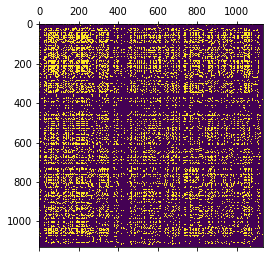

In [25]:
import matplotlib.pyplot as plt


train_edgelist

df = pd.crosstab(train_edgelist.index_x, train_edgelist.index_y)

idx = df.columns.union(df.index)
df2 = df.reindex(index = idx, columns=idx, fill_value=0)
df2

plt.matshow(df2)